# Using the QuriPartsTranspiler in Qamomile
This tutorial demonstrates the usage of the QuriPartsTranspiler in Qamomile and provides key examples to guide users in applying it effectively.

## Translating a Hamiltonian into QuriParts

We begin by defining a Hamiltonian as a test example and use our transpiler to convert it into a QuriParts-compatible representation. 
This step shows how seamlessly the Hamiltonian defined in our own library’s format can be translated into operators recognized by QuriParts.

In [1]:
import numpy as np
import qamomile
from qamomile.quri_parts.transpiler import QuriPartsTranspiler
from qamomile.core.operator import Hamiltonian, Pauli, X, Y, Z
from qamomile.core.circuit import QuantumCircuit as QamomileCircuit
from qamomile.core.circuit import (
    QuantumCircuit,
    SingleQubitGate,
    TwoQubitGate,
    ParametricSingleQubitGate,
    ParametricTwoQubitGate,
    SingleQubitGateType,
    TwoQubitGateType,
    ParametricSingleQubitGateType,
    ParametricTwoQubitGateType,
    Parameter
)

import jijmodeling as jm
import jijmodeling_transpiler.core as jmt
import networkx as nx

In this snippet, we start from a custom-defined Hamiltonian using various Pauli operators (X, Y, Z) and then employ `QuriPartsTranspiler` to convert it into a format directly suitable for QuriParts. By printing out `quriParts_hamiltonian`, we can verify the correctness of the translation.

In [2]:
hamiltonian = Hamiltonian()
hamiltonian += X(0)*Z(1)
hamiltonian += Y(0)*Y(1)*Z(2)*X(3)*X(4)

transpiler = QuriPartsTranspiler()
quriParts_hamiltonian = transpiler.transpile_hamiltonian(hamiltonian)

quriParts_hamiltonian

{frozenset({(0, <SinglePauli.X: 1>), (1, <SinglePauli.Z: 3>)}): 1.0,
 frozenset({(0, <SinglePauli.Y: 2>),
            (1, <SinglePauli.Y: 2>),
            (2, <SinglePauli.Z: 3>),
            (3, <SinglePauli.X: 1>),
            (4, <SinglePauli.X: 1>)}): 1.0}

## Constructing a Parameterized Quantum Circuit

Next, we build a parameterized quantum circuit using QamomileCircuit. We include single-qubit rotations (e.g., rx, ry, rz) and controlled variants (crx, crz, cry), as well as two-qubit entangling gates (rxx, ryy, rzz). The parameters (theta, beta, gamma) allow for flexible variational adjustments.

In [6]:
qc = QamomileCircuit(3)
theta = Parameter("theta")
beta = Parameter("beta")
gamma = Parameter("gamma")

qc.rx(theta, 0)
qc.ry(beta, 1)
qc.rz(gamma, 2)
qc.rxx(gamma, 0 ,1)
qc.ryy(theta, 1 ,2)
qc.rzz(beta, 2 ,0)

transpiler = QuriPartsTranspiler()
qp_circuit = transpiler.transpile_circuit(qc)

## Formulating the MaxCut Problem and Converting it into a Quantum Form

In the following part, we demonstrate how to take a classical optimization problem—MaxCut—and encode it into an Ising-form Hamiltonian. We then construct a QAOA-style ansatz circuit that, when executed and optimized, attempts to solve the MaxCut instance.

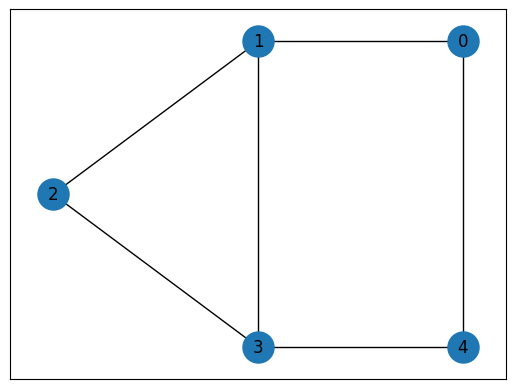

In [7]:
def maxcut_problem() -> jm.Problem:
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    x = jm.BinaryVar("x", shape=(V,))
    e = jm.Element("e", belong_to=E)
    i = jm.Element("i", belong_to=V)
    j = jm.Element("j", belong_to=V)

    problem = jm.Problem("Maxcut", sense=jm.ProblemSense.MAXIMIZE)
    si = 2 * x[e[0]] - 1
    sj = 2 * x[e[1]] - 1
    si.set_latex("s_{e[0]}")
    sj.set_latex("s_{e[1]}")
    obj = 1 / 2 * jm.sum(e, (1 - si * sj))
    problem += obj
    return problem

def maxcut_instance():
    # Construct a simple graph for a MaxCut instance
    G = nx.Graph()
    G.add_nodes_from([0, 1, 2, 3, 4])
    G.add_edges_from([(0, 1), (0, 4), (1, 2), (1, 3), (2, 3), (3, 4)])
    E = [list(edge) for edge in G.edges]
    instance_data = {"V": G.number_of_nodes(), "E": E}
    pos = {0: (1, 1), 1: (0, 1), 2: (-1, 0.5), 3: (0, 0), 4: (1, 0)}
    nx.draw_networkx(G, pos, node_size=500)
    return instance_data

problem = maxcut_problem()
instance_data = maxcut_instance()
compiled_instance = jmt.compile_model(problem, instance_data)

# Convert the compiled problem into a QAOA form.
qaoa_converter = qamomile.core.qaoa.QAOAConverter(compiled_instance)
qaoa_converter.ising_encode()

p = 5
qaoa_hamiltonian = qaoa_converter.get_cost_hamiltonian()
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=p)

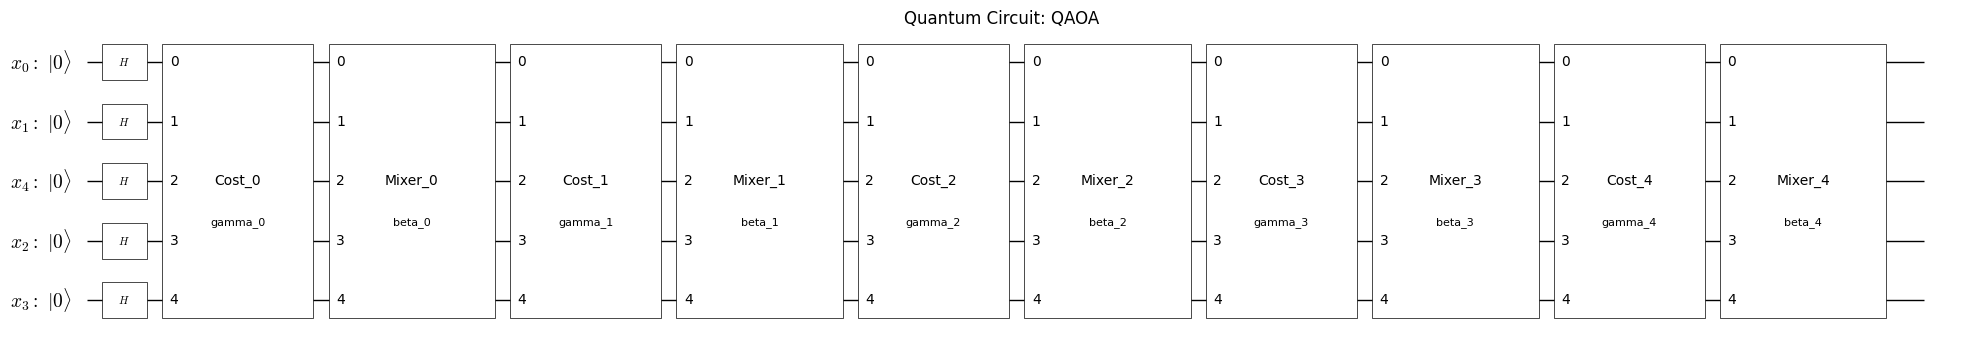

In [8]:
from qamomile.core.circuit.drawer import plot_quantum_circuit

plot_quantum_circuit(qaoa_circuit)

We have now translated the MaxCut problem into a cost Hamiltonian suitable for a QAOA-like algorithm. The parameter `p` determines the number of layers of problem and mixer Hamiltonians. Each layer’s parameters are variational and will be tuned to minimize the expvalue, ideally leading to a good solution to the MaxCut instance.

## Transpiling and Executing the QAOA Circuit in PennyLane

With the QAOA circuit and Hamiltonian defined, we use the transpiler again, this time to convert the QAOA circuit and cost Hamiltonian into QuriParts forms:

In [10]:
transpiler = QuriPartsTranspiler()
# Transpile the QAOA circuit to QuriParts
qp_circuit = transpiler.transpile_circuit(qaoa_circuit)

# Transpile the QAOA Hamitltonian to QuriParts
qp_hamiltonian = transpiler.transpile_hamiltonian(qaoa_hamiltonian)
qp_hamiltonian

{frozenset({(0, <SinglePauli.Z: 3>), (1, <SinglePauli.Z: 3>)}): 0.5,
 frozenset({(0, <SinglePauli.Z: 3>), (2, <SinglePauli.Z: 3>)}): 0.5,
 frozenset({(1, <SinglePauli.Z: 3>), (3, <SinglePauli.Z: 3>)}): 0.5,
 frozenset({(1, <SinglePauli.Z: 3>), (4, <SinglePauli.Z: 3>)}): 0.5,
 frozenset({(3, <SinglePauli.Z: 3>), (4, <SinglePauli.Z: 3>)}): 0.5,
 frozenset({(2, <SinglePauli.Z: 3>), (4, <SinglePauli.Z: 3>)}): 0.5,
 PauliLabel(): -3.0}

Here, `qk_circuit` is the QuriParts circuit generated from the Qamomile QAOA ansatz and `qk_hamiltonian` is build from Qamomile Hamiltonian based on the mathematical model.

## Optimizing the Parameters

Finally, we optimize the variational parameter and attempt to find those that yield better results (e.g., lower cost for the MaxCut objective):

In [11]:
from typing import Sequence
from scipy.optimize import minimize
from quri_parts.core.state import quantum_state, apply_circuit
from quri_parts.qulacs.estimator import create_qulacs_vector_parametric_estimator

cost_history = []
# Cost estimator function


cb_state = quantum_state(qp_circuit.qubit_count, bits=0)
parametric_state = apply_circuit(qp_circuit, cb_state)


estimator = create_qulacs_vector_parametric_estimator()

cost_history = []
def cost_fn(param_values: Sequence[float]) -> float:
    estimate = estimator(qp_hamiltonian, parametric_state, param_values)
    cost = estimate.value.real
    cost_history.append(cost)
    return cost


# Create initial parameters
initial_params = np.random.uniform(low=-np.pi / 4, high=np.pi / 4, size=2 * p)

# Run QAOA optimization
result = minimize(
    cost_fn,
    initial_params,
    method="COBYLA",
    options={"maxiter": 2000},
)
print(result)

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -4.711600340952039
       x: [ 1.579e+00 -9.337e-01  2.224e+00  1.642e+00  9.104e-01
           -9.487e-01 -7.253e-01 -2.557e-01 -4.168e-01  8.613e-01]
    nfev: 2000
   maxcv: 0.0


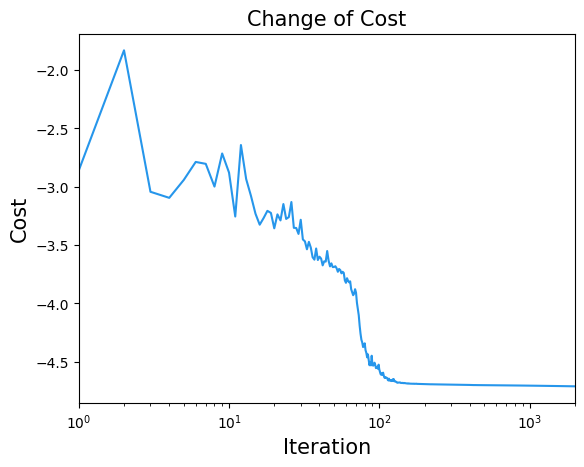

In [12]:
import matplotlib.pyplot as plt

plt.title("Change of Cost", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.xscale("log")
plt.xlim(1, result.nfev)
plt.plot(cost_history, label="Cost", color="#2696EB")
plt.show()

Once the optimized parameters are obtained, we use QuriParts's `create_qulacs_vector_sampler` to sample from the parameterized quantum circuit to get the circuit counts.

In [14]:
# Run Optimized QAOA circuit
from quri_parts.qulacs.sampler import create_qulacs_vector_sampler

sampler = create_qulacs_vector_sampler()
bounded_circuit = qp_circuit.bind_parameters(result.x)
qp_result = sampler(bounded_circuit, 1000)

In [18]:
bitcounts = {bin(i)[2:].zfill(qp_circuit.qubit_count): count for i, count in qp_result.items()}

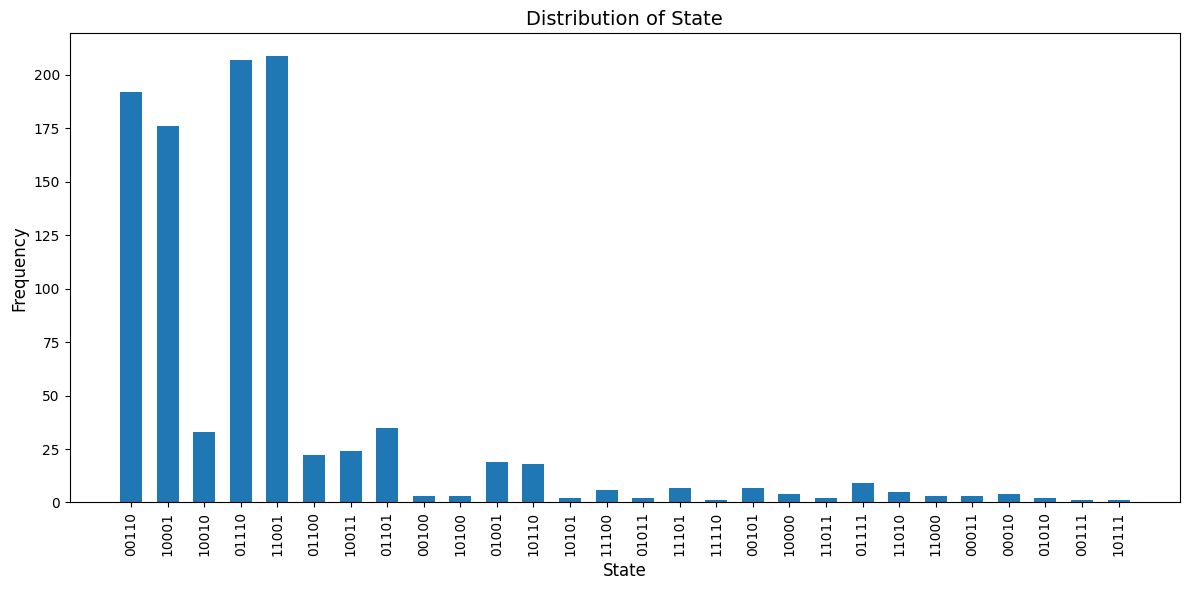

In [22]:
# Prepare data for plotting
keys = list(bitcounts.keys())
values = list(bitcounts.values())

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(keys, values, width=0.6)
plt.xlabel("State", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of State", fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

## Evaluating the Results
From the `qp_result` and `qubit_count` obtained earlier, we can transfer them to a sampleset by `qaoa_converter.decode`.
The sampleset can select only the feasible solutions and then we examine the distribution of the objective function values.

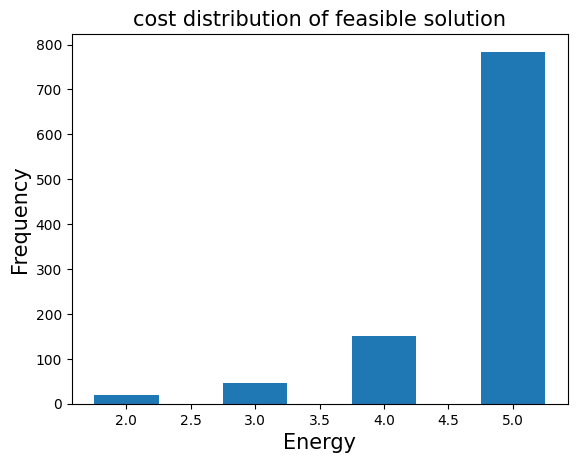

In [26]:
sampleset = qaoa_converter.decode(transpiler, (qp_result, qp_circuit.qubit_count))

plot_data = {}
for sample in sampleset.feasibles():
    if sample.eval.objective in plot_data:
        plot_data[sample.eval.objective] += sample.num_occurrences
    else:
        plot_data[sample.eval.objective] = sample.num_occurrences

plt.bar(plot_data.keys(), plot_data.values(), width=0.5)
plt.title("cost distribution of feasible solution", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xlabel("Energy", fontsize=15)
plt.show()